In [1]:
import warnings
warnings.filterwarnings('ignore')
import time


- Importation des modules
- Chargement du fichier de données et retraitement du fichier de données
- Transformation du DataFrame des MetaDonnée en Matrice

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from numba import jit

df = pd.read_csv("Data_Satisfaction_retraitement2.csv")

df = df.drop("Unnamed: 0",axis=1)
df = df.dropna(axis = 0, how = "all", subset =["Commentaires_reduit"])

y = df["star"]
Meta_Matrix = df.drop(["star","Commentaires_reduit"], axis =1).to_numpy()

- Vectorization des commentaires selon la méthode CountVectorizer
- Concatenation de la Matrice des Commentaires Vectorisé et de la Matrice des méta données
- Séparation des données en ensemble de test et d'entrainement

In [3]:
vectorizer = CountVectorizer(min_df = 150)
Com_Matrix = vectorizer.fit_transform(df["Commentaires_reduit"]).todense()
X = np.concatenate([Com_Matrix,Meta_Matrix],axis=1)
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

Application Algorithme de GridSearch sur les modeles : GradientBoosting, RandomForest, et SVC

In [4]:
@jit
def modelisation(X_train,X_test):
    gb = GradientBoostingClassifier()
    rf = RandomForestClassifier()
    svc = SVC()

    param_grid_gb = {"n_estimators":[100,150,200], "learning_rate":[0.5,1.0,1.5], "max_depth": [1,2,3],"random_state" : [100] }
    param_grid_svc = {'C':[0.1,1,10,30],"kernel" :["linear", "poly", "rbf", "sigmoid"],"random_state" : [100] }
    param_grid_rf = {'max_features': ["sqrt", "log2", None ],"random_state" : [100] }

    gridcvs = {}
    for pgrid, clf, name in zip((param_grid_gb, param_grid_rf, param_grid_svc),
                                (gb, rf, svc),
                                ('GB', 'RF', 'SVM')):
        gcv = GridSearchCV(clf, pgrid, cv=5, n_jobs = -1, refit=True).fit(X_train,y_train)
        gridcvs[name] = gcv
    return gridcvs 


In [5]:
start = time.time()
my_grid = modelisation(X_train,X_test)
end = time.time()
print("duration=", end - start)

duration= 3433.356805086136


Affichage des meilleurs parametres ainsi que des meilleurs score de précisions par models

In [6]:
print(my_grid["GB"].best_params_)
print(my_grid["RF"].best_params_)
print(my_grid["SVM"].best_params_)

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 200, 'random_state': 100}
{'max_features': 'log2', 'random_state': 100}
{'C': 0.1, 'kernel': 'linear', 'random_state': 100}


In [7]:
print(my_grid["GB"].best_score_)
print(my_grid["RF"].best_score_)
print(my_grid["SVM"].best_score_)

0.7047198437174864
0.6973550669703548
0.6984069641602229


Application Algorithme de GridSearch sur le modèle de régression logistique

In [8]:
from sklearn import linear_model 
from sklearn import model_selection
from sklearn.model_selection import train_test_split

rl = linear_model.LogisticRegression()
param_grid_rl = { 'C':[0.1,1,10,30], 'max_iter' : [100,300,1000], "random_state" : [100]}
grid_rl = model_selection.GridSearchCV(estimator=rl, param_grid= param_grid_rl )
grid_rl.fit(X_train, y_train)

print(grid_rl.best_params_)
print(grid_rl .best_score_) 

{'C': 0.1, 'max_iter': 100, 'random_state': 100}
0.7015637286333384


Application du model ayant eu la meilleur précision sur les données d'entrainement au set de test.

In [9]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)

0.7012323414487527

Création d'un réseau de neurone

In [10]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model

In [11]:
y = y.replace(to_replace = [1,2,3,4,5], value = [0,1,2,3,4])
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

In [12]:
X_train_dim = X_train.shape[1]
inputs = Input(shape = X_train_dim, name = "Input")
couche={}
n = 3
for i in range(1,n+1):
    if i !=n:
        couche[i] = Dense(units = X_train_dim-i*(X_train_dim//n), activation = "tanh", name = "Dense_"+str(i))
    else:
        couche[i] = Dense(units = 5, activation = "softmax", name = "Dense_"+str(i))

x=couche[1](inputs)
for i in range(2,n):   
    x=couche[i](x)
outputs=couche[n](x)

    

model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 393)]             0         
                                                                 
 Dense_1 (Dense)             (None, 262)               103228    
                                                                 
 Dense_2 (Dense)             (None, 131)               34453     
                                                                 
 Dense_3 (Dense)             (None, 5)                 660       
                                                                 
Total params: 138,341
Trainable params: 138,341
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = 'val_accuracy',
                        min_delta = 0.001,
                        patience = 10,
                        factor = 0.5, 
                        cooldown = 10,
                        verbose = 1)


from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor = 'val_accuracy',
                    min_delta = 0.0001,
                    patience = 30,
                    verbose = 1,
                    restore_best_weights = True)

In [14]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])
model_history = model.fit(X_train,y_train,epochs=500,batch_size=150,validation_split=0.1, callbacks = [reducelr, earlystop])

Epoch 1/500
80/80 [==============================] - 1s 5ms/step - loss: 0.8762 - accuracy: 0.6668 - val_loss: 0.7751 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.7254 - accuracy: 0.7138 - val_loss: 0.7899 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.7059 - accuracy: 0.7204 - val_loss: 0.7922 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.7264 - val_loss: 0.7825 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.7285 - val_loss: 0.7925 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.7326 - val_loss: 0.7872 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 7/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6

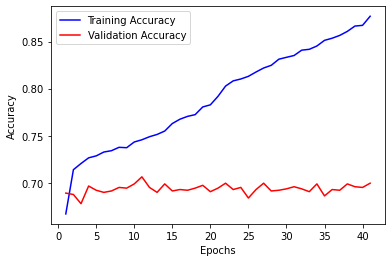

In [15]:
import matplotlib.pyplot as plt

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()
plt.show()

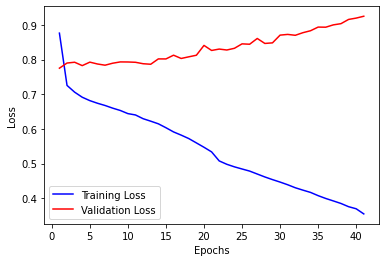

In [19]:

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['loss'],
         label = 'Training Loss',
         color = 'blue')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_loss'], 
         label = 'Validation Loss',
         color = 'red')

plt.legend()
plt.show()

Estimation de la performance du reseau de neurone

In [16]:
test_pred = model.predict(X_test)

y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)


104/104 [==============================] - 0s 860us/step


In [17]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class)) 

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       964
           1       0.25      0.17      0.20       248
           2       0.34      0.21      0.26       316
           3       0.47      0.45      0.46       628
           4       0.79      0.88      0.83      1171

    accuracy                           0.68      3327
   macro avg       0.53      0.52      0.52      3327
weighted avg       0.65      0.68      0.66      3327

[[ 860   35   26   31   12]
 [ 108   41   34   56    9]
 [  38   55   66  131   26]
 [  27   27   63  284  227]
 [  25    5    7  107 1027]]
